100%|██████████| 1000000/1000000 [03:10<00:00, 5239.02it/s]


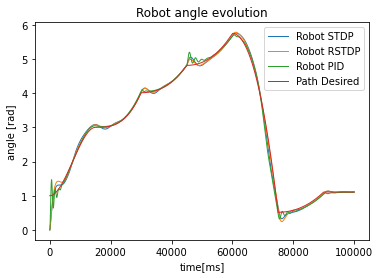

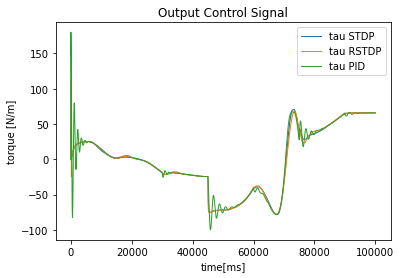

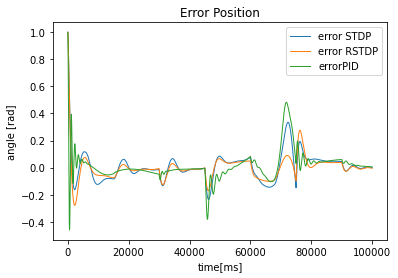

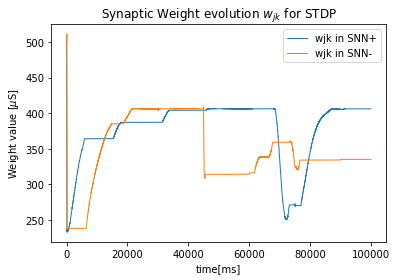

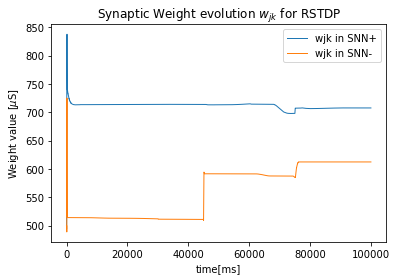

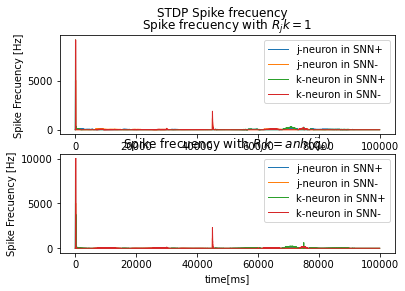

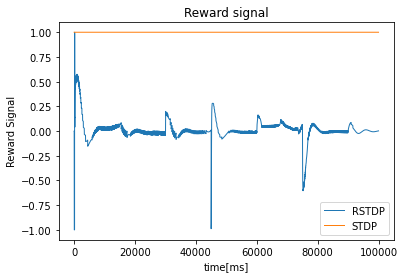

In [2]:
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt


#variables temporales
epoch_length = 15000             #cuanto dura cada iteracion de la trayectoria 15s
n_epoch = 6                     #cuantas iteraciones de la trayectoria se haccen
midSim = (epoch_length * n_epoch)/2*10     #mitad de la simulacion 
t_extra = 10000                      #tiempo de simulacion extra, la trayectoria deseada ha terminado 15s
dt = 0.1
t_ini = 0
t_fin = (epoch_length * n_epoch) + t_extra
tiempo = np.arange(t_ini, t_fin, dt)


class RSTDP:
    Ap = 1
    Am = -Ap
    tE = 10
    wmin = 1            #peso sinaptico minimo 1mS (Conductancia)
    wmax = 1000         #peso sinaptico max 1000mS (Conductancia)
    def __init__(self):
        self.w = 500         #peso sinaptico inicial, inicializado de manera aleatoria
        self.E = 0             #traza de egibilidad
        self.dE = 0
        self.w_hist = []
    
    def update(self, dd_prev, dd_post, R):
        Ap = self.Ap
        Am = self.Am
        tE = self.tE

        w = self.w
        E = self.E

        Wpre =  Ap * dd_prev 
        Wpost = Am * dd_post
        dE = (-E/tE) + Wpre + Wpost
        E = E + dt * dE
        dw = R * E
        w = w + dt * dw

        if(w<self.wmin):
            w = 1
        elif(w>self.wmax):
            w = self.wmax

        self.E = E
        self.w = w
        self.w_hist.append(w)

class StepFowardEncoder:
    Ic = 140
    def __init__(self, thr):
        self.base = 0
        self.thr = thr
    
    def encode(self, x):
        IcP = 0
        IcN = 0
        base = self.base
        thr = self.thr
        if(x > (base + thr)):
            IcP = self.Ic
            base = base + thr
        elif(x < (base - thr)):
            IcN = self.Ic
            base = base - thr
        self.base = base
        return [IcP, IcN]

class StepFowardDecoder:
    def __init__(self, thr):
        self.base = 0
        self.thr = thr

    def decode(self, spk_pos, spk_neg):
        thr = self.thr
        base = self.base
        if(spk_pos == 1):
            base = self.base +  thr
        elif(spk_neg == 1):
            base = self.base - thr
        self.base = base
        return base

class LIF:
    #Modelo LIF 
    Rm = 10              #Resistencia de membrana 10MOhms (10e6)
    Cm = 1               #Capacitancia de membrana 1nF (1e-9)
    tm = Rm * Cm         #constante temporal membrana  [ms]
    El = -70             #voltaje de reposo  mV
    vreset = -75         #voltaje de reset   mV
    vth = -55            #voltaje de  umbral mV
    vspike = 20          #voltaje de disparo m
    T = 50
    def __init__(self):
        self.V = self.El
        self.tf = []
        self.frec_hist = []
        self.Isyn_hist = []

    def sim_neuron(p, t, Isyn):
        V = p.V
        dV = (p.El - V + p.Rm * Isyn)/p.tm
        V = V + dt * dV
        diracDelta = 0
        if(V >= p.vth):
            V = p.vreset               #se resetea el voltaje de membrana
            diracDelta = 1             #lo mismo que diracDelta con t=tf
            p.tf.append(t)           #agregando el nuevo tiempo de disparo
        
        #calculando la frecuencia
        p.checkFiringTimes(t)
        f = (len(p.tf)) * (1000/p.T)

        p.frec_hist.append(f)
        p.Isyn_hist.append(Isyn)
        p.V = V
        return diracDelta
    
    def checkFiringTimes(self, t):
        #metodo que solo guarda los tiempos de disparo de neurona que estan dentro del lapso T
        tf = np.array(self.tf)
        new_tf = tf[(t - tf) < self.T]
        self.tf = new_tf.tolist()
        

class LIFspk(LIF):
    #Modelo LIF aumentado que calcula la corriente de entrada en funcion de los disparos
    def __init__(self):
        self.V = self.El
        self.Isyn = 0
        self.tf = []
        self.frec_hist = []

    def sim_neuron(p, t, w_dd):
        Isyn = p.Isyn
        V = p.V

        dIsyn = (-Isyn + p.Cm * w_dd)/p.tm
        dV = (p.El - V + p.Rm * Isyn)/p.tm
        Isyn = Isyn + dt * dIsyn
        V = V + dt * dV

        diracDelta = 0
        if(V >= p.vth):
            V = p.vreset               #se resetea el voltaje de membrana
            diracDelta = 1                 #lo mismo que diracDelta con t=tf
            p.tf.append(t)           #agregando el nuevo tiempo de disparo
        
        #calculando la frecuencia
        p.checkFiringTimes(t)
        f = (len(p.tf)) * (1000/p.T)
        p.frec_hist.append(f)

        p.Isyn = Isyn
        p.V = V
        return diracDelta
        
class Pendulo:
    dof = 1
    m = 1    ##kgs
    l = 2.5  #metros
    g = 9.81 #m/s^2
    k = 0.1 #coefFriccion
    th_max = np.pi
    th_min = -np.pi

    def __init__(self, X):
        #variables de estado
        self.th = X[0]
        self.dth = X[1]
        self.th_hist = []
        self.dth_hist = []
        self.ddth_hist = []
        self.tau_hist = []      #vector historial del control proporcionado al sistema  

    
    def simulate(self, t,tau):
        th = self.th
        dth = self.dth
        ddth = (tau/(self.m * self.l**2)) - (self.g/self.l) * np.sin(th) - self.k*dth
        
        dth = dth + 0.001 * dt * ddth       #integrando dth (se le agrega el 0.001 por el factor de simulacion en milisegundos
        th = th + 0.001 * dt * dth          #integrando th
        #guardando en historial del objeto
        self.ddth_hist.append(ddth)
        self.dth_hist.append(dth)
        self.th_hist.append(th)
        self.tau_hist.append(tau)
        self.dth = dth
        self.th = th

        #retornando para la simulacion
        return np.array([th, dth, ddth])

class Path_desired:
    thd_hist = []                     #historial
    dthd_hist = []                    #historial
    ddthd_hist = []                    #historial
    def __init__(self):
        ti = 0
        tf = epoch_length
        qi = 1
        qf = 3
        dqi = 0
        dqf = 0
        self.compute_coeficients(ti, tf, qi, qf, dqi, dqf)

    def compute_coeficients(self, ti, tf, qi, qf, dqi, dqf):
        self.ti = ti
        self.tf = tf
        self.qi = qi
        self.qf = qf
        self.dqi = dqi
        self.dqf = dqf

        g = np.array([qi, qf, dqi, dqf])
        ti2 = ti * ti
        ti3 = ti2 * ti
        tf2 = tf * tf
        tf3 = tf2 * tf
        T = np.array([  [1, ti,     ti2,            ti3],
                        [1, tf,     tf2,            tf3],
                        [0,  1,     2 * ti,     3 * ti2],
                        [0,  1,     2 * tf2,    3 * tf3]])
        a = np.dot(np.linalg.inv(T),g)
        self.a = a

    def calculate(self, t):
        if(t>epoch_length*n_epoch):
            #trayectoria deseada termina 
            q = self.thd_hist[-1]
            dq = self.dthd_hist[-1]
            ddq = self.ddthd_hist[-1]
        else:
            if((t - self.ti)>epoch_length):
                ti = t
                tf = t + epoch_length
                qi = self.qf
                qf = 2*np.pi * np.random.rand()
                dqi = 0
                dqf = 0
                self.compute_coeficients(ti, tf, qi, qf, dqi, dqf)
                
            a = self.a
            tt = t * t
            ttt = tt * t
            q = a[0] + a[1] * t + a[2] * tt + a[3] * ttt
            dq = a[1] + a[2] * t + a[3] * tt
            ddq = a[2] + a[3] * t

        ##guardando historiall
        self.thd_hist.append(q)
        self.dthd_hist.append(dq)
        self.ddthd_hist.append(ddq)
        return np.array([q, dq, ddq])

class Network:
    def __init__(self, q):
        self.j_layer = [LIF() for j in range(q)]
        self.k_layer = [LIFspk() for k in range(q)]
        self.wjk = [RSTDP() for jk in range(q)]
        self.Rjk = np.ones(q)

    def get_wjk(self):
        wjk = []
        for jk, syn in enumerate(self.wjk):
            wjk.append(syn.w)
        return wjk

    def simulate(self, t, Ic_vector):
        tjf = []
        for j, neuron in enumerate(self.j_layer):
            tf = neuron.sim_neuron(t,Ic_vector[j])
            tjf.append(tf)
        
        #simulando disparos capa k
        tkf = []
        wjk = self.get_wjk()
        for k, neuron in enumerate(self.k_layer):
            w_dd = tjf[k] * wjk[k]
            tf = neuron.sim_neuron(t,w_dd)
            tkf.append(tf)
        
        #actualizando sinapsis wjk
        for k, syn in enumerate(self.wjk):
            syn.update(tjf[k], tkf[k], self.Rjk[k])

        return np.array(tkf)        #retornando los valores  de la nueva 


def PID_Control(e_th, i_eth, e_dth):
    #control PID sintonizado maanualmente por ziegler nichols
    Kc = 300
    Pc = 100
    Kp = 0.6 * Kc
    Ki = 0.5 * Pc  
    Kd = Pc/8
    return Kp * e_th + Ki * i_eth +  Kd * e_dth

trayectoria = Path_desired()
robot_SNN = Pendulo([0, 0])
tau_SNN = 0
ieth_SNN = 0
     
#encoders y redes parte proporcional
#cada red tendra tantas neuronas por capa como grados de libertad tenga el robot
SNNP = Network(robot_SNN.dof)
SNNN = Network(robot_SNN.dof)
encoderEth = StepFowardEncoder(0.001)  
decoderTauP = StepFowardDecoder(0.2) 
r_hist = []

#ROBOT STDP 
robot_STDP = Pendulo([0,0])
tau_STDP = 0
ieth_STDP = 0
SNNP_STDP = Network(robot_STDP.dof)
SNNN_STDP = Network(robot_STDP.dof)
encoderEth_STDP = StepFowardEncoder(0.001)  
decoderTauP_STDP = StepFowardDecoder(0.2) 



#robot PID
robot_PID = Pendulo([0,0])
tau_PID = 0
ieth_PID = 0



teqdm = range(len(tiempo))        
for a in tqdm(teqdm):
    t = tiempo[a]
    
    qd = trayectoria.calculate(t)

    #Simulando robot RSTDP
    q_snn = robot_SNN.simulate(t, tau_SNN)
    eq = qd - q_snn
    ieth_SNN = ieth_SNN + 0.001 * dt * eq[0]

    #estableciendo senal de recompensa
    R = np.array([np.tanh(eq[2])])
    r_hist.append(R)
    SNNP.Rjk = R
    SNNN.Rjk = R

    [IcP, IcM] = encoderEth.encode(eq[0] +ieth_SNN + eq[1])
    spk_pos = SNNP.simulate(t, [IcP])
    spk_neg = SNNN.simulate(t, [IcM])
    tau_SNN = decoderTauP.decode(spk_pos, spk_neg)


    #simulando Robot STDP
    q_STDP = robot_STDP.simulate(t, tau_STDP)
    eq_STDP = qd - q_STDP
    ieth_STDP = ieth_STDP + 0.001 * dt * eq_STDP[0]

    [IcP_STDP, IcM_STDP] = encoderEth_STDP.encode(eq_STDP[0] +ieth_STDP + eq_STDP[1])
    spk_pos_STDP = SNNP_STDP.simulate(t, [IcP_STDP])
    spk_neg_STDP = SNNN_STDP.simulate(t, [IcM_STDP])
    tau_STDP = decoderTauP_STDP.decode(spk_pos_STDP, spk_neg_STDP)

    # control PID Tradicional
    q_PID = robot_PID.simulate(t, tau_PID) 
    eq_PID = qd - q_PID
    ieth_PID = ieth_PID + 0.001 * dt * eq_PID[0]
    tau_PID = PID_Control(eq_PID[0], ieth_PID,  eq_PID[1])

 
    if(a == midSim):
        #cambia el coeficciente de friccion a la mitad del recorrido
        robot_SNN.k = 0.5
        robot_SNN.m = 3
        robot_STDP.k = 0.5
        robot_STDP.m = 3
        robot_PID.k = 0.5
        robot_PID.m = 3
        

fig2, (ax2) = plt.subplots(1, figsize = (6.4,3.2))
ax2.plot(tiempo,robot_STDP.th_hist,linewidth = 1, label = 'Robot STDP')
ax2.plot(tiempo,robot_SNN.th_hist,linewidth = 1, label = 'Robot RSTDP')
ax2.plot(tiempo,robot_PID.th_hist,linewidth = 1, label = 'Robot PID')
ax2.plot(tiempo,trayectoria.thd_hist,linewidth = 1, label = 'Path Desired')
ax2.legend()
ax2.set(xlabel = 'time[ms]' , ylabel = 'angle [rad]')
ax2.set_title('Robot angle evolution')
fig2.savefig('th.pdf')

fig2, (ax2) = plt.subplots(1, figsize = (6.4,3.2))
ax2.plot(tiempo,robot_STDP.tau_hist,linewidth = 1, label = 'tau STDP')
ax2.plot(tiempo,robot_SNN.tau_hist,linewidth = 1, label = 'tau RSTDP')
ax2.plot(tiempo,robot_PID.tau_hist,linewidth = 1, label = 'tau PID')
ax2.legend()
ax2.set(xlabel = 'time[ms]' , ylabel = 'torque [N/m]')
ax2.set_title('Output Control Signal')
fig2.savefig('tau.pdf')


fig2, (ax2) = plt.subplots(1, figsize = (6.4,3.2))
ax2.plot(tiempo,np.array(trayectoria.thd_hist) - np.array(robot_STDP.th_hist),linewidth = 1, label = 'error STDP')
ax2.plot(tiempo,np.array(trayectoria.thd_hist) - np.array(robot_SNN.th_hist),linewidth = 1, label = 'error RSTDP')
ax2.plot(tiempo,np.array(trayectoria.thd_hist) - np.array(robot_PID.th_hist),linewidth = 1, label = 'errorPID')
ax2.legend()
ax2.set(xlabel = 'time[ms]' , ylabel = 'angle [rad]')
ax2.set_title('Error Position')
fig2.savefig('ErrorPosition.pdf')




fig2, (ax2) = plt.subplots(1, figsize = (6.4,3.2))
for i, syn in np.ndenumerate(SNNP_STDP.wjk):
    ax2.plot(tiempo,syn.w_hist,linewidth = 1, label = 'wjk in SNN+')
for i, syn in np.ndenumerate(SNNN_STDP.wjk):
    ax2.plot(tiempo,syn.w_hist,linewidth = 1, label = 'wjk in SNN-')
ax2.legend()
ax2.set(xlabel = 'time[ms]' , ylabel = 'Weight value [$\mu$S]')
ax2.set_title('Synaptic Weight evolution $w_{jk}$ for STDP')
fig2.savefig('wjk_STDP.pdf')


fig2, (ax2) = plt.subplots(1, figsize = (6.4,3.2))
for i, syn in np.ndenumerate(SNNP.wjk):
    ax2.plot(tiempo,syn.w_hist,linewidth = 1, label = 'wjk in SNN+')
for i, syn in np.ndenumerate(SNNN.wjk):
    ax2.plot(tiempo,syn.w_hist,linewidth = 1, label = 'wjk in SNN-')
ax2.legend()
ax2.set(xlabel = 'time[ms]' , ylabel = 'Weight value [$\mu$S]')
ax2.set_title('Synaptic Weight evolution $w_{jk}$ for RSTDP')
fig2.savefig('wjk.pdf')



fig2, (ax2) = plt.subplots(2, figsize = (6.4,3.2))
for j, neuron in enumerate(SNNP_STDP.j_layer):
    ax2[0].plot(tiempo,neuron.frec_hist,linewidth = 1, label = 'j-th in SNN+')
for j, neuron in enumerate(SNNN_STDP.j_layer):
    ax2[0].plot(tiempo,neuron.frec_hist,linewidth = 1, label = 'j-th in SNN-')
for j, neuron in enumerate(SNNP_STDP.k_layer):
    ax2[0].plot(tiempo,neuron.frec_hist,linewidth = 1, label = 'k-th in SNN+')
for j, neuron in enumerate(SNNN_STDP.k_layer):
    ax2[0].plot(tiempo,neuron.frec_hist,linewidth = 1, label = 'k-th in SNN-')

for j, neuron in enumerate(SNNP.j_layer):
    ax2[1].plot(tiempo,neuron.frec_hist,linewidth = 1, label = 'j-th in SNN+')
for j, neuron in enumerate(SNNN.j_layer):
    ax2[1].plot(tiempo,neuron.frec_hist,linewidth = 1, label = 'j-th in SNN-')
for j, neuron in enumerate(SNNP.k_layer):
    ax2[1].plot(tiempo,neuron.frec_hist,linewidth = 1, label = 'k-th in SNN+')
for j, neuron in enumerate(SNNN.k_layer):
    ax2[1].plot(tiempo,neuron.frec_hist,linewidth = 1, label = 'k-th in SNN-')


ax2[0].legend()
ax2[1].legend()
ax2[0].set(xlabel = 'time[ms]' , ylabel = 'Spike Frecuency [Hz]')
ax2[1].set(xlabel = 'time[ms]' , ylabel = 'Spike Frecuency [Hz]')

fig2.suptitle('Spike frecuency')
fig2.savefig('FrecSNNSTDP.pdf')



fig2, (ax2) = plt.subplots(1, figsize = (6.4,3.2))
ax2.plot(tiempo,r_hist,linewidth = 1, label = 'RSTDP')
ax2.plot(tiempo,np.ones(len(tiempo)),linewidth = 1, label = 'STDP')
ax2.legend()
ax2.set(xlabel = 'time[ms]' , ylabel = 'Reward Signal')
ax2.set_title('Reward signal')
fig2.savefig('Reward.pdf')
    

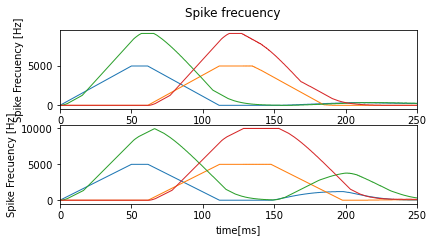

In [28]:

fig2, (ax2) = plt.subplots(2, figsize = (6.4,3.2))
for j, neuron in enumerate(SNNP_STDP.j_layer):
    ax2[0].plot(tiempo,neuron.frec_hist,linewidth = 1, label = 'j-th in SNN+')
for j, neuron in enumerate(SNNN_STDP.j_layer):
    ax2[0].plot(tiempo,neuron.frec_hist,linewidth = 1, label = 'j-th in SNN-')
for j, neuron in enumerate(SNNP_STDP.k_layer):
    ax2[0].plot(tiempo,neuron.frec_hist,linewidth = 1, label = 'k-th in SNN+')
for j, neuron in enumerate(SNNN_STDP.k_layer):
    ax2[0].plot(tiempo,neuron.frec_hist,linewidth = 1, label = 'k-th in SNN-')

for j, neuron in enumerate(SNNP.j_layer):
    ax2[1].plot(tiempo,neuron.frec_hist,linewidth = 1, label = 'j-th in SNN+')
for j, neuron in enumerate(SNNN.j_layer):
    ax2[1].plot(tiempo,neuron.frec_hist,linewidth = 1, label = 'j-th in SNN-')
for j, neuron in enumerate(SNNP.k_layer):
    ax2[1].plot(tiempo,neuron.frec_hist,linewidth = 1, label = 'k-th in SNN+')
for j, neuron in enumerate(SNNN.k_layer):
    ax2[1].plot(tiempo,neuron.frec_hist,linewidth = 1, label = 'k-th in SNN-')


# ax2[0].legend()
# ax2[1].legend()
ax2[0].set(xlabel = 'time[ms]' , ylabel = 'Spike Frecuency [Hz]')
ax2[1].set(xlabel = 'time[ms]' , ylabel = 'Spike Frecuency [Hz]')
ax2[0].set_xlim(0,250)
ax2[1].set_xlim(0,250)
fig2.suptitle('Spike frecuency')
fig2.savefig('FrecSNNSTDPZOOM.pdf')


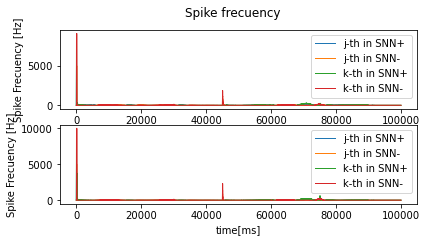

In [29]:

fig2, (ax2) = plt.subplots(2, figsize = (6.4,3.2))
for j, neuron in enumerate(SNNP_STDP.j_layer):
    ax2[0].plot(tiempo,neuron.frec_hist,linewidth = 1, label = 'j-th in SNN+')
for j, neuron in enumerate(SNNN_STDP.j_layer):
    ax2[0].plot(tiempo,neuron.frec_hist,linewidth = 1, label = 'j-th in SNN-')
for j, neuron in enumerate(SNNP_STDP.k_layer):
    ax2[0].plot(tiempo,neuron.frec_hist,linewidth = 1, label = 'k-th in SNN+')
for j, neuron in enumerate(SNNN_STDP.k_layer):
    ax2[0].plot(tiempo,neuron.frec_hist,linewidth = 1, label = 'k-th in SNN-')

for j, neuron in enumerate(SNNP.j_layer):
    ax2[1].plot(tiempo,neuron.frec_hist,linewidth = 1, label = 'j-th in SNN+')
for j, neuron in enumerate(SNNN.j_layer):
    ax2[1].plot(tiempo,neuron.frec_hist,linewidth = 1, label = 'j-th in SNN-')
for j, neuron in enumerate(SNNP.k_layer):
    ax2[1].plot(tiempo,neuron.frec_hist,linewidth = 1, label = 'k-th in SNN+')
for j, neuron in enumerate(SNNN.k_layer):
    ax2[1].plot(tiempo,neuron.frec_hist,linewidth = 1, label = 'k-th in SNN-')


ax2[0].legend()
ax2[1].legend()
ax2[0].set(xlabel = 'time[ms]' , ylabel = 'Spike Frecuency [Hz]')
ax2[1].set(xlabel = 'time[ms]' , ylabel = 'Spike Frecuency [Hz]')
# ax2[0].set_xlim(0,250)
# ax2[1].set_xlim(0,250)
fig2.suptitle('Spike frecuency')
fig2.savefig('FrecSNNSTDP.pdf')


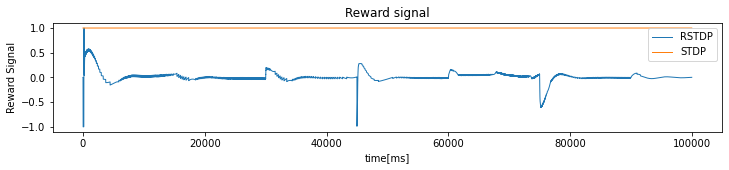

In [31]:

fig2, (ax2) = plt.subplots(1, figsize = (12,2))
ax2.plot(tiempo,r_hist,linewidth = 1, label = 'RSTDP')
ax2.plot(tiempo,np.ones(len(tiempo)),linewidth = 1, label = 'STDP')
ax2.legend()
ax2.set(xlabel = 'time[ms]' , ylabel = 'Reward Signal')
ax2.set_title('Reward signal')
fig2.savefig('Reward.pdf')